In [8]:
dataname="trg_multi"
modelname = 'multires-7classes-v0'
gpuid=0

class_names=["Fat", "Muscular", "Vessel", "Gland", "Stroma", "Tumor", "Epithelium"]
#class_names=["Fat", "Muscular", "Vessel", "Gland", "Stroma", "Tumor", "Necrosis", "Epithelium"]
nclasses=len(class_names)


# --- training params
batch_size=128
patch_size=64 #currently, this needs to be 224 due to densenet architecture
num_epochs = 100
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import DenseNet

from albumentations import *
from albumentations.pytorch import ToTensor


import scipy

import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

from torchsummary import summary
import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix
from  MultiResSmallNetwork import MergeSmallNetworks

In [3]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname

        self.img_transform=img_transform
        
        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]
            self.nitems=db.root.imgres1.shape[0]
        
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here. need to do it everytime, otherwise hdf5 crashes

        with tables.open_file(self.fname,'r') as db:
            self.imgres1=db.root.imgres1
            self.imgres2=db.root.imgres2
            
            self.labels=db.root.labels

            #get the requested image and mask from the pytable
            imgres1 = self.imgres1[index,:,:,:]
            imgres2 = self.imgres2[index,:,:,:]
            
            label = self.labels[index]
        
        
        imgres1_new = imgres1
        imgres2_new = imgres2
        
        if self.img_transform:
            #img_new = self.img_transform(image=img)['image']
            trans = self.img_transform(image=imgres1,imgres2=imgres2)
            imgres1_new = trans['image']
            imgres2_new = trans['imgres2']

        return imgres1_new, imgres2_new, label
    def __len__(self):
        return self.nitems

In [9]:
device = torch.device('cuda')
checkpoint = torch.load(f"../../models/multi/{modelname}.pth", map_location=lambda storage, loc: storage)

In [10]:
from  MultiResSmallNetwork import MergeSmallNetworks
model=MergeSmallNetworks(nclasses = nclasses, outputsize = 8 ).to(device)
model.load_state_dict(checkpoint["model_dict"])

<All keys matched successfully>

In [8]:
#summary(model.res1,input_size=(3,64,64))

In [9]:
#summary(model.res2,input_size=(3,64,64))

In [11]:
img_transform = Compose([
        RandomScale(scale_limit=0.1,p=.9),
        PadIfNeeded(min_height=patch_size,min_width=patch_size),        
        VerticalFlip(p=.5),
        HorizontalFlip(p=.5),
        #Blur(p=.5),
        #Downscale(p=.25, scale_min=0.64, scale_max=0.99),
        GaussNoise(p=.5, var_limit=(10.0, 50.0)),
        GridDistortion(p=.5, num_steps=5, distort_limit=(-0.3, 0.3), 
                       border_mode=cv2.BORDER_REFLECT),
        ISONoise(p=.5, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
        RandomBrightness(p=.5, limit=(-0.2, 0.2)),
        RandomContrast(p=.5, limit=(-0.2, 0.2)),
        RandomGamma(p=.5, gamma_limit=(80, 120), eps=1e-07),
        MultiplicativeNoise(p=.5, multiplier=(0.9, 1.1), per_channel=True, elementwise=True),
        HueSaturationValue(hue_shift_limit=20,sat_shift_limit=10,val_shift_limit=10,p=.9),
        Rotate(p=1, border_mode=cv2.BORDER_REFLECT),
        CenterCrop(patch_size,patch_size),
        ToTensor()
    ], additional_targets={'imgres2':'image'})

In [12]:
dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset(f"../../data/processed/trg-multi-7classes-{phase}.pytable", img_transform = img_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=False, num_workers=0,pin_memory=True) 
    print(f"{phase} dataset size:\t{len(dataset[phase])}")

train dataset size:	56500
val dataset size:	11300


In [14]:
cmatrix = np.zeros((nclasses,nclasses))
#cmatrix = {key: np.zeros((nclasses,nclasses)) for key in phases}
model.eval()   # Set model to evaluate mode
phase = 'val'
Y_val = []
Y_pred = []
for ii , (Xres1, Xres2, label) in enumerate(dataLoader['val']): #for each of the batches
            Xres1 = Xres1.to(device)  # [Nbatch, 3, H, W]
            Xres2 = Xres2.to(device)  # [Nbatch, 3, H, W]
            label = label.type('torch.LongTensor').to(device)  # [Nbatch, 1] with class indices (0, 1, 2,...num_classes)

            with torch.set_grad_enabled(False): #dynamically set gradient computation, in case of validation, this isn't needed
                                                            #disabling is good practice and improves inference time

                
                prediction = model.dualfoward(Xres1,Xres2)  # [N, Nclass]
                #prediction = model.res1(Xres1)  # [N, Nclass]
                #prediction = model.res2(Xres2)  # [N, Nclass]


              

                p=prediction.detach().cpu().numpy()
                cpredflat=np.argmax(p,axis=1).flatten()
                yflat=label.cpu().numpy().flatten()

                CM = scipy.sparse.coo_matrix((np.ones(yflat.shape[0], dtype=np.int64), (yflat, cpredflat)),
                        shape=(nclasses, nclasses), dtype=np.int64,
                        ).toarray()
                cmatrix=cmatrix+CM
                Y_val = Y_val + list(yflat)
                Y_pred = Y_pred + list(cpredflat)
                    

Automatically created module for IPython interactive environment
Normalized confusion matrix
[[9.79e-01 6.67e-04 5.33e-03 5.33e-03 8.00e-03 0.00e+00 1.33e-03]
 [3.45e-03 8.49e-01 5.72e-02 2.41e-03 4.86e-02 7.93e-03 3.14e-02]
 [5.00e-03 3.58e-02 9.04e-01 3.33e-03 1.92e-02 1.08e-02 2.17e-02]
 [1.17e-02 3.33e-03 1.67e-03 8.73e-01 7.00e-02 3.67e-02 3.33e-03]
 [1.48e-02 5.31e-02 1.86e-02 3.52e-02 8.49e-01 1.90e-02 1.00e-02]
 [8.33e-04 2.25e-02 2.08e-02 3.83e-02 4.50e-02 8.28e-01 4.42e-02]
 [1.00e-03 1.10e-02 2.90e-02 5.00e-03 2.50e-02 8.00e-03 9.21e-01]]


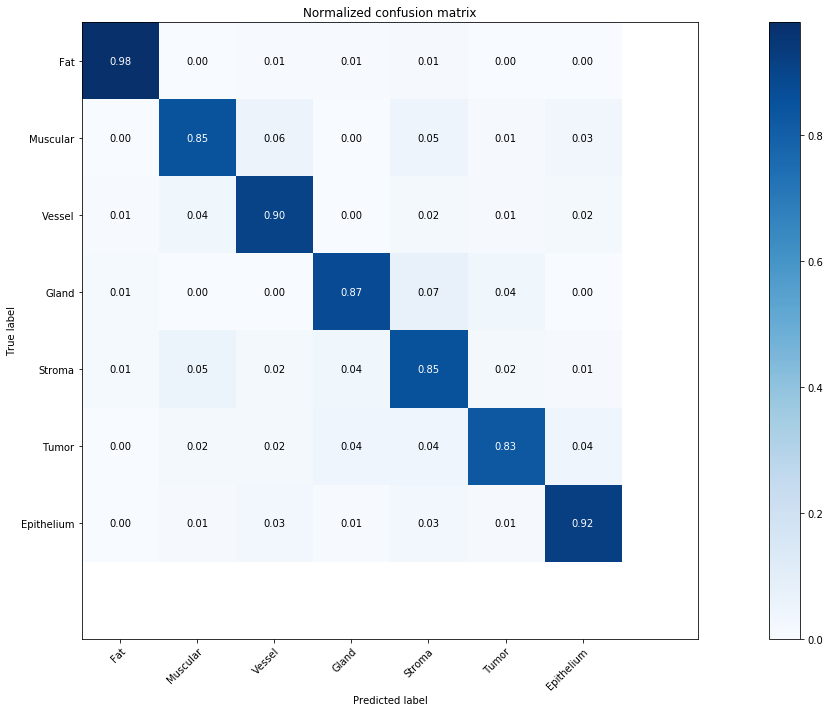

In [16]:
%matplotlib inline
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names=np.array(class_names, dtype='<U10')
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots(figsize=(20,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, 7.5) 
    plt.ylim(7.5, -0.5)
    plt.savefig('cmatrix.png', dpi = 1000, bbox_inches='tight')
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plot_confusion_matrix(Y_val, Y_pred, classes=class_names,
                     # title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
fig = plot_confusion_matrix(Y_val, Y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()